# Model 1 MobileNetV2

## Import Libraries

In [65]:
# Common imports
import os
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# folder
import zipfile
import random
import shutil

# System libraries
from pathlib import Path
import os.path

# Augmentation
from tensorflow import image

# Model imports
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential

# Visualization imports
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import clear_output as cls

# Split imports
from sklearn.model_selection import train_test_split

# Evaluation imports
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Import series of helper functions for our notebook
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves
cls()

print ('modules loaded')

modules loaded


## 📝 Data Preprocessing

### 📥 Data Loading | Transform Data

In [8]:
# Connect to Goggle Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
# The name of the zip file to be extracted
zip_file = "/content/gdrive/MyDrive/Capstone/Dataset/pelita_dataset.zip"

# Extraction of zip files
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("/content/pelita_dataset")

In [23]:
# Checking the class of the dataset
dataset = '/content/pelita_dataset'
classes = os.listdir(dataset)
print(classes)
print('total classes: ', len(classes))

['battery', 'lamp', 'mouse', 'phone', 'mineral_bottle', 'kettle', 'laptop', 'rice_cooker', 'spray_bottle', 'cable', 'monitor', 'plastic_bag', 'cups', 'toothbrush', 'keyboard']
total classes:  15


### 📅 Placing data into a Dataframe

In [15]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [16]:
image_df

,Filepath,Label
0,/content/pelita_dataset/battery/00038.jpg,battery
1,/content/pelita_dataset/battery/00136.jpg,battery
2,/content/pelita_dataset/battery/00060.jpg,battery
3,/content/pelita_dataset/battery/00267.jpg,battery
4,/content/pelita_dataset/battery/00061.jpg,battery
...,...,...
4482,/content/pelita_dataset/mineral_bottle/00124.png,mineral_bottle
4483,/content/pelita_dataset/mineral_bottle/00278.png,mineral_bottle
4484,/content/pelita_dataset/mineral_bottle/00108.png,mineral_bottle
4485,/content/pelita_dataset/mineral_bottle/00104.png,mineral_bottle


### 🔭Visualizing images from the dataset

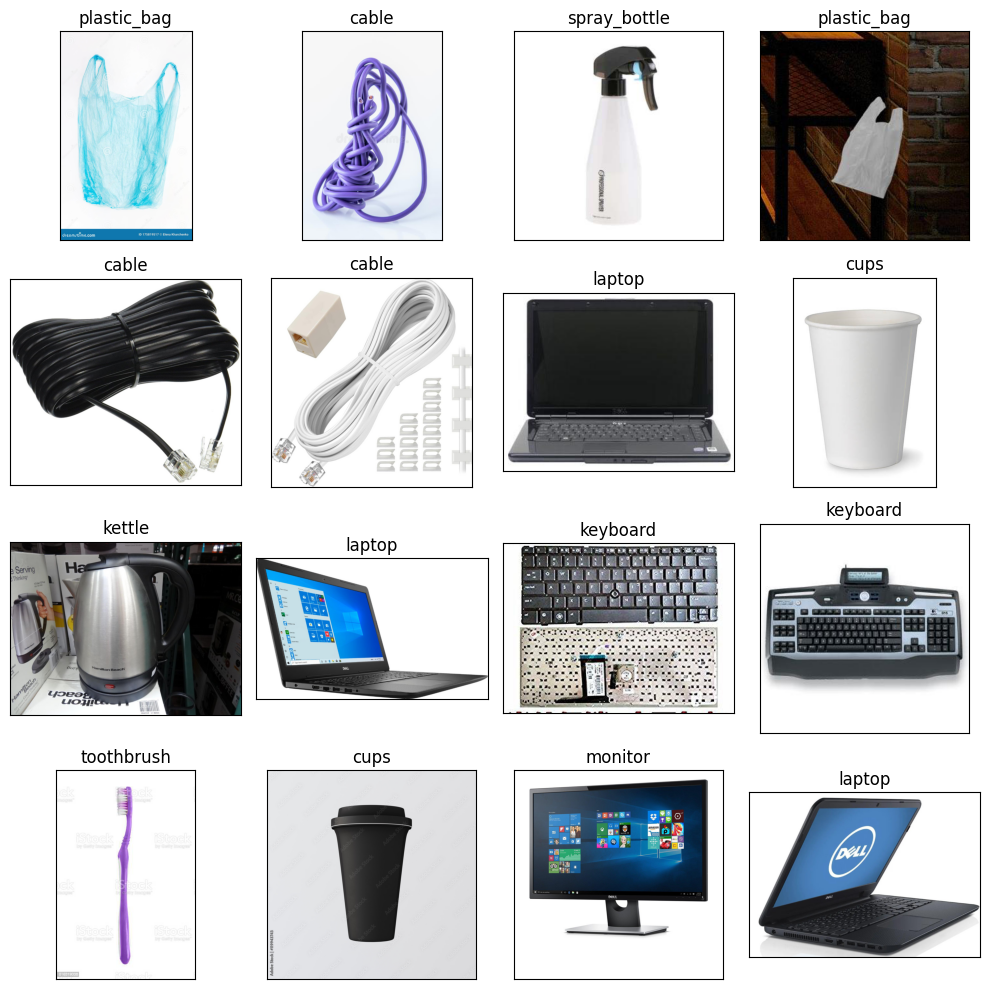

In [17]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

### Split Data | Data Preprocessing

In [19]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.1, shuffle=True, random_state=42)

In [20]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

### Image Augmentation

In [46]:
IMAGE_SIZE = 300
N_CLASSES = len(classes)
BATCH_SIZE = 32
OPTIMIZER = Adam(.0001)
LOSS = categorical_crossentropy
METRICS = ['accuracy']

In [53]:
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]  
test_steps = int(length/test_batch_size)
print ('test batch size: ' , test_batch_size, '  test steps: ', test_steps)

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test batch size:  1   test steps:  449
Found 3231 validated image filenames belonging to 15 classes.
Found 807 validated image filenames belonging to 15 classes.
Found 449 validated image filenames belonging to 15 classes.


## 🤹 Modelling

### 🤹 Pre-Trained Model Load

In [54]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [55]:
mobilenetv2 = MobileNetV2(
    input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

mobilenetv2.trainable = False 

In [56]:
# Create checkpoint callback
checkpoint_path = "pelita_app"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [57]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(
    # watch the val loss metric
    monitor = "val_loss",
    patience = 5,
    # if val loss decreases for 3 epochs in a row, stop training
    restore_best_weights = True
)

### 🚄 Fine Tuning | Train the model

In [58]:
inputs = mobilenetv2.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(mobilenetv2.output)
x = Dropout(0,2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(N_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=METRICS)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [64]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "pelita_app"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/pelita_app/20230611-182359
Epoch 1/100
101/101 [==============================] - 519s 5s/step - loss: 1.8007 - accuracy: 0.6119 - val_loss: 0.7439 - val_accuracy: 0.9418
Epoch 2/100
101/101 [==============================] - 460s 5s/step - loss: 0.4374 - accuracy: 0.9387 - val_loss: 0.2233 - val_accuracy: 0.9653
Epoch 3/100
101/101 [==============================] - 462s 5s/step - loss: 0.1898 - accuracy: 0.9619 - val_loss: 0.1368 - val_accuracy: 0.9827
Epoch 4/100
101/101 [==============================] - 428s 4s/step - loss: 0.1166 - accuracy: 0.9780 - val_loss: 0.1048 - val_accuracy: 0.9789
Epoch 5/100
101/101 [==============================] - 471s 5s/step - loss: 0.0808 - accuracy: 0.9873 - val_loss: 0.0915 - val_accuracy: 0.9827
Epoch 6/100
101/101 [==============================] - 471s 5s/step - loss: 0.0576 - accuracy: 0.9920 - val_loss: 0.0819 - val_accuracy: 0.9851
Epoch 7/100
101/101 [==============================] - 406s 4s

### ✔️Model Evaluation

In [66]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.04701
Test Accuracy: 98.44%


### 📉Visualizing loss curves

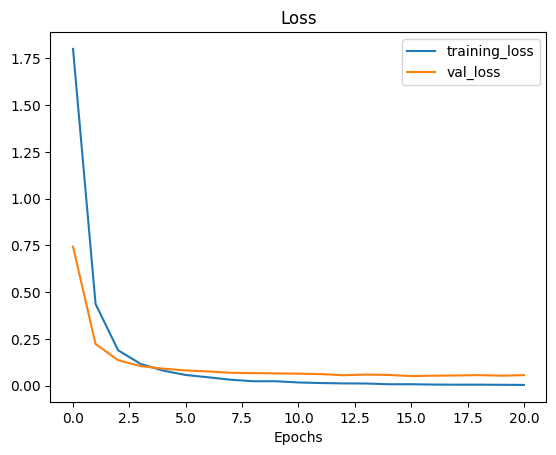

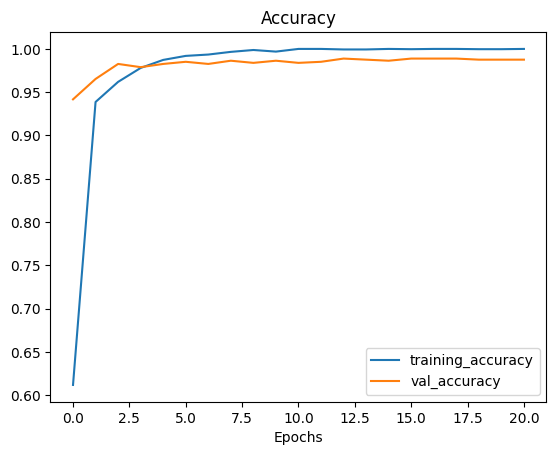

In [67]:
plot_loss_curves(history)

### 🔮Making predictions on the Test Data

In [68]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

15/15 [==============================] - 45s 3s/step
The first 5 predictions: ['battery', 'monitor', 'phone', 'plastic_bag', 'mouse']


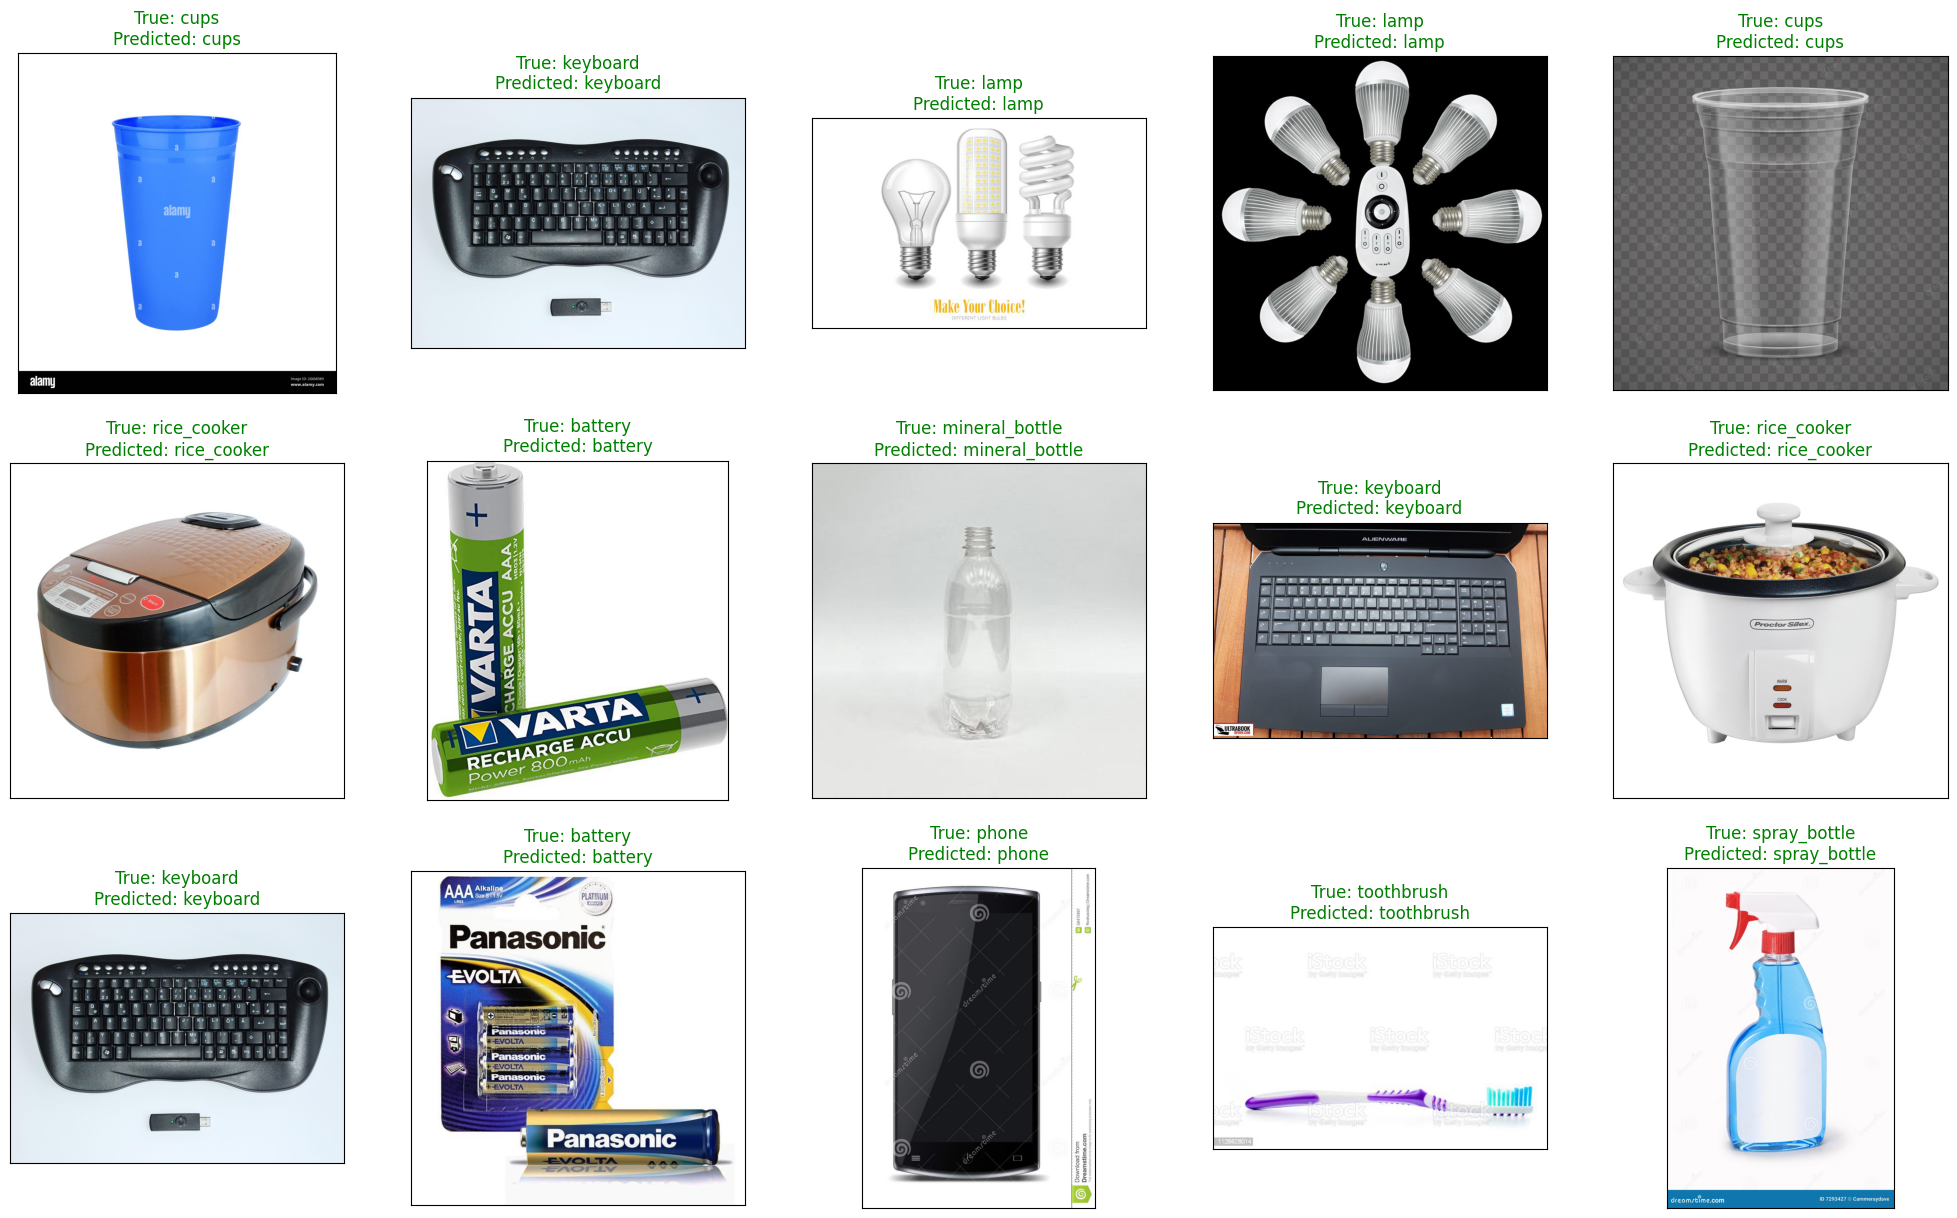

<Figure size 640x480 with 0 Axes>

In [69]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

### 📊Plotting the Classification Reports and Confusion Matrix

In [70]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

       battery       1.00      1.00      1.00        37
         cable       1.00      1.00      1.00        25
          cups       1.00      0.96      0.98        27
        kettle       1.00      0.97      0.98        31
      keyboard       1.00      1.00      1.00        33
          lamp       0.97      1.00      0.98        30
        laptop       1.00      0.96      0.98        25
mineral_bottle       0.97      1.00      0.98        32
       monitor       0.96      1.00      0.98        26
         mouse       0.97      1.00      0.99        33
         phone       1.00      1.00      1.00        30
   plastic_bag       0.96      0.96      0.96        26
   rice_cooker       0.97      1.00      0.99        33
  spray_bottle       0.97      0.94      0.95        33
    toothbrush       1.00      0.96      0.98        28

      accuracy                           0.98       449
     macro avg       0.98      0.98      0.98 

In [71]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
battery,1.000000,1.000000,1.000000,37.00000
cable,1.000000,1.000000,1.000000,25.00000
cups,1.000000,0.962963,0.981132,27.00000
kettle,1.000000,0.967742,0.983607,31.00000
keyboard,1.000000,1.000000,1.000000,33.00000
lamp,0.967742,1.000000,0.983607,30.00000
laptop,1.000000,0.960000,0.979592,25.00000
mineral_bottle,0.969697,1.000000,0.984615,32.00000
monitor,0.962963,1.000000,0.981132,26.00000
mouse,0.970588,1.000000,0.985075,33.00000


In [72]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

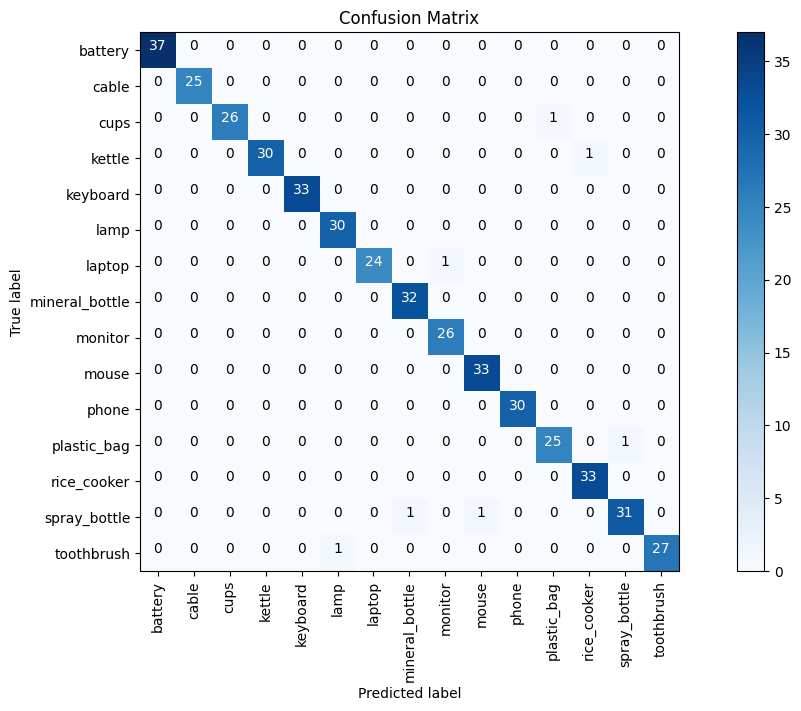

In [73]:
make_confusion_matrix(y_test, pred, list(labels.values()))

### Text Upload With File

Saving 00183.jpg to 00183.jpg
1/1 [==============================] - 0s 22ms/step
gambar ini menunjukkan straw


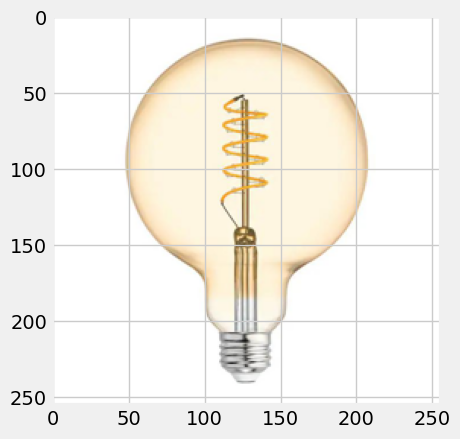

In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()
 
for fn in uploaded.keys():
  # predicting images
  path = fn
  img = Image.open(path).convert('RGB')
  img = img.resize(img_size)
  
  x = np.array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
 
  classes = model.predict(images, batch_size=10)
  idx = np.argmax(classes)

  class_labels = list(train_gen.class_indices.keys())
  print(f"gambar ini menunjukkan {class_labels[idx]}")
  imgplot = plt.imshow(img)

## Save Model

.H5

.TFLite